# Use the 🤗 transformers-native implementation of ColQwen2

[![Colab](https://img.shields.io/badge/Open_in_Colab-F9AB00?logo=googlecolab&logoColor=fff&style=for-the-badge)](https://colab.research.google.com/github/tonywu71/colpali-cookbooks/blob/main/examples/use_transformers_native_colqwen2.ipynb)
[![GitHub](https://img.shields.io/badge/ColPali_Cookbooks-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/tonywu71/colpali-cookbooks)
[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)
[![Hugging Face](https://img.shields.io/badge/Vidore-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/vidore)
<!-- TODO: Update with ColQwen2 Hf thread url when posted -->
<!-- [![X](https://img.shields.io/badge/Thread-%23000000?style=for-the-badge&logo=X&logoColor=white)](https://x.com/tonywu_71/status/1809183824464560138) -->

[![Hugging Face](https://img.shields.io/badge/ColQwen2_hf_transformers_documentation-FFD21E?style=for-the-badge&logo=huggingface&logoColor=000)](https://huggingface.co/docs/transformers/main/en/model_doc/colqwen2)

## Introduction

[ColQwen2](https://huggingface.co/docs/transformers/main/en/model_doc/colqwen2) is a variant of the [ColPali](https://huggingface.co/docs/transformers/main/en/model_doc/colpali) model designed to retrieve documents by analyzing their visual features. Unlike traditional systems that rely heavily on text extraction and OCR, ColQwen2 treats each page as an image. It uses the [Qwen2-VL](./qwen2_vl) backbone to capture not only text, but also the layout, tables, charts, and other visual elements to create detailed multi-vector embeddings that can be used for retrieval by computing pairwise late interaction similarity scores. This offers a more comprehensive understanding of documents and enables more efficient and accurate retrieval.

![ColPali Architecture](https://github.com/tonywu71/colpali-cookbooks/blob/main/assets/architecture/colpali_architecture.jpeg?raw=true)

Unlike ColPali, a key advantage of ColQwen2 is its ability to handle arbitrary image resolutions and aspect ratios, making it particularly suitable for document processing as images are not resized into fixed-size squares.

The following notebook guides you through using the native ColPali model implementation from `transformers` 🤗 for inference, scoring, and interpretability. While there are a few minor differences in the API, all the core functionalities are identical to the original implementation from `colpali-engine==0.3.x`.

### Hardware Requirements 🛠️

You can run it on Google Colab (using the free-tier T4 GPU) or locally (tested on a M2 Pro MacBook).

In case ColQwen2's update hasn't got released yet, you can pip install from the `main` source branch of 🤗 `transformers`.

In [1]:
# For Part 1 about inference:
# TODO: Update after PR gets merged
# !pip install -q -U accelerate huggingface_hub pillow git+https://github.com/huggingface/transformers.git torch
!pip install -q -U accelerate huggingface_hub pillow git+https://github.com/tonywu71/transformers.git@add-colqwen2 torch

# For Part 2 about similarity maps:
# Use --no-deps to avoid version conflict with transformers
!pip install -q --no-deps "colpali-engine[interpretability]>=0.3.9,<0.4.0"
!pip install -q -U einops matplotlib seaborn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Part 1: Run inference with ColQwen2 🚀

### First, a few imports! ✨

In [2]:
from io import BytesIO
from typing import List

import requests
import torch
from IPython.display import display
from PIL import Image
from transformers import ColQwen2ForRetrieval, ColQwen2Processor
from transformers.utils.import_utils import is_flash_attn_2_available


def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

### Load the ColQwen2 model and processor 🏎️

In this cookbook, we will use the [`vidore/colqwen2-v1.0-hf`](https://huggingface.co/vidore/colqwen2-v1.0-hf) checkpoint. Click on the link to read the model card! 📖

In [3]:
model_name = "vidore/colqwen2-v1.0-hf"

model = ColQwen2ForRetrieval.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2" if is_flash_attn_2_available() else None,
).eval()

processor = ColQwen2Processor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Image and query inputs 📄

Let's use 2 query-image pairs showcased in the [ColPali paper](https://arxiv.org/abs/2407.01449) as examples.

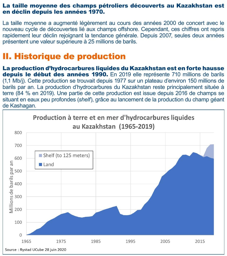

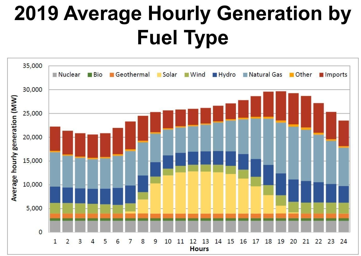

In [4]:
# Load the image and query inputs
urls: List[str] = [
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true",
    "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true",
]
images: List[Image.Image] = [load_image_from_url(url) for url in urls]

queries: List[str] = [
    "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?",
    "Which hour of the day had the highest overall electricity generation in 2019?",
]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

### Preprocess and embed the queries and the images 🧩

Now let's generate the embeddings for our images and queries. Note how ColPali's embeddings—unlike regular dense embeddings—are multi-vector, i.e., they are 2-dimensional.

More importantly, they are used within in the late interaction paradigm, making the representations fine-grained, rich, and efficient at retrieval time. Read this awesome [post](https://x.com/lateinteraction/status/1894696983077785980) from Omar Khattab for why late interaction paradigm is such a game-changer! 🧵

In [5]:
# Preprocess inputs
batch_images = processor(images=images).to(model.device)
batch_queries = processor(text=queries).to(model.device)

# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings  # (batch_size, seq_len, embedding_dim)
    query_embeddings = model(**batch_queries).embeddings  # (batch_size, seq_len, embedding_dim)

### Score the queries against the images ✅

Now let's score all the query-image pairs using the late interaction similarity. Here's an amazing visual definition crafted by [Leonie Monigatti](https://x.com/helloiamleonie/status/1844030115237200336) for those who need a recap! 👀

<img src="https://pbs.twimg.com/media/GZdPne0XQAAd-5H?format=jpg&name=large" style="zoom:40%;" />

You should obtain a score matrix where the maximum scores are on the diagonal. This means the model has retrieved the correct image for each query. 🙌🏼

In [6]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[21.3750,  9.1250],
        [ 9.8750, 22.0000]], dtype=torch.bfloat16)

## Part 2: Generate similarity maps 🗺️

By superimposing the late interaction similarity heatmap on top of the original image, we can visualize the
most salient image patches with respect to each term of the query, yielding interpretable insights
into ColPali's focus zones. 📍 We call this a *similarity map*.

This section will show you how to generate similarity maps for a given query and image pair. Keep your 👀 peeled!

### Imports + a few more utils! 🔧

In [7]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize


def get_n_patches(
    processor: ColQwen2Processor,
    image_size: Tuple[int, int],
    patch_size: int,
    spatial_merge_size: int,
) -> Tuple[int, int]:
    """
    Get the number of patches created by the processor along each dimension of the image.
    """
    height_new, width_new = smart_resize(
        width=image_size[0],
        height=image_size[1],
        factor=patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.size["shortest_edge"],
        max_pixels=processor.image_processor.size["longest_edge"],
    )

    n_patches_x = width_new // patch_size // spatial_merge_size
    n_patches_y = height_new // patch_size // spatial_merge_size

    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    """
    Get a tensor mask that identifies the image tokens in the batch.
    """
    image_token_id = processor.tokenizer.added_tokens_encoder[processor.image_token]
    return batch_images.input_ids == image_token_id

### Get the per-token similarity maps

First step is to compute all the similarity scores between the query tokens and the image patches. Then, we reshape the resulting tensor to make the image structure appear clearly in the tensor shape. 🔀

In [8]:
# Get the number of patches and the image mask for each image of the batch
batched_n_patches: List[Tuple[int, int]] = []  # [(n_patches_x, n_patches_y), ...]

for image in images:
    n_patches = get_n_patches(
        processor=processor,
        image_size=image.size,
        patch_size=model.vlm.config.vision_config.patch_size,
        spatial_merge_size=model.vlm.config.vision_config.spatial_merge_size,
    )
    batched_n_patches.append(n_patches)

image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Batch-compute the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=batched_n_patches,
    image_mask=image_mask,
)

print("For the first image:")
print(f"  - Number of image patches: {batched_n_patches[0]}")
print(f"  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(batched_similarity_maps[0].shape)}")

For the first image:
  - Number of image patches: (26, 29)
  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = (32, 26, 29)


### Show the possible tokens to analyze

In [9]:
# While all similarity maps are computed, we will only visualize the idx-th one
idx = 0
similarity_maps = batched_similarity_maps[idx]  # (query_length, n_patches_x, n_patches_y)

# Remove the padding tokens and the query augmentation tokens
query_content = processor.decode(batch_queries.input_ids[idx])
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()

# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

{0: 'Query',
 1: ':',
 2: 'ĠQu',
 3: 'elle',
 4: 'Ġpartie',
 5: 'Ġde',
 6: 'Ġla',
 7: 'Ġproduction',
 8: 'Ġp',
 9: 'Ã©t',
 10: 'ro',
 11: 'li',
 12: 'Ã¨re',
 13: 'Ġdu',
 14: 'ĠKazakhstan',
 15: 'Ġprov',
 16: 'ient',
 17: 'Ġde',
 18: 'Ġchamps',
 19: 'Ġen',
 20: 'Ġmer',
 21: 'Ġ?'}


### Select the query token of interest and visualize the associated similarity map

Selected token: `Ġmer`


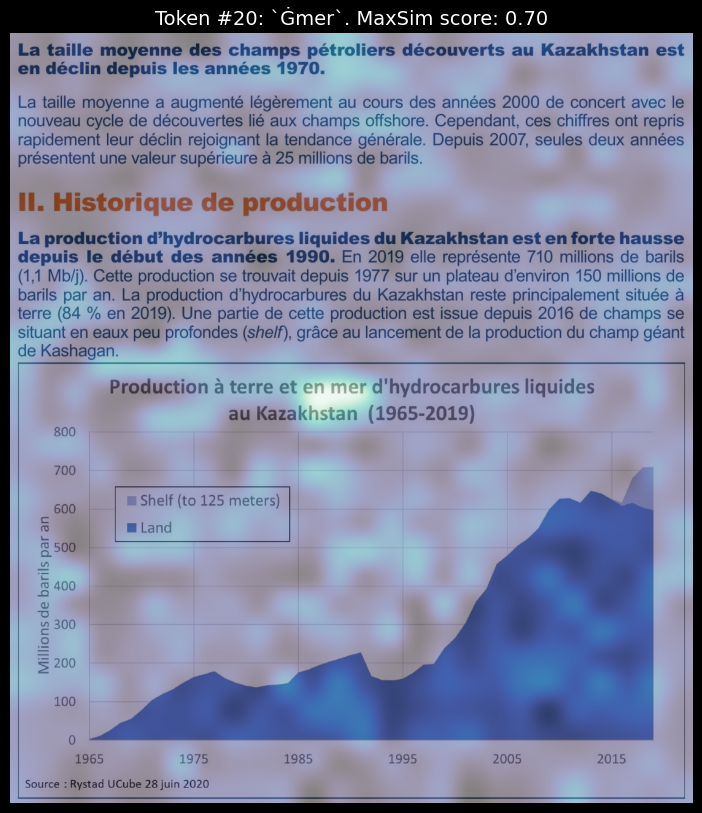

In [10]:
# Choose a token using its index
token_idx = 20  # e.g. if "20: 'Ġmer',", set to 20 to choose the token 'Ġmer'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=images[idx],
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig

The brighter the patch, the higher similarity score it has with the selected token. In particular, similarity maps exhibit OCR capabilities and chart understanding of the ColQwen2 model. 🧠

### Generate and save similarity maps for all query tokens

You can use the higher-level function `generate_similarity_maps` to generate similarity maps for all query tokens.

In [11]:
plots = plot_all_similarity_maps(
    image=image,
    query_tokens=query_tokens,
    similarity_maps=similarity_maps,
    figsize=(8, 8),
    show_colorbar=False,
    add_title=True,
)

for idx, (fig, ax) in enumerate(plots):
    savepath = f"similarity_map_{idx}.png"
    fig.savefig(savepath, bbox_inches="tight")
    print(f"Similarity map for token `{query_tokens[idx]}` saved at `{savepath}`")

plt.close("all")

/usr/local/lib/python3.11/dist-packages/colpali_engine/interpretability/similarity_maps.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Similarity map for token `Query` saved at `similarity_map_0.png`
Similarity map for token `:` saved at `similarity_map_1.png`
Similarity map for token `ĠQu` saved at `similarity_map_2.png`
Similarity map for token `elle` saved at `similarity_map_3.png`
Similarity map for token `Ġpartie` saved at `similarity_map_4.png`
Similarity map for token `Ġde` saved at `similarity_map_5.png`
Similarity map for token `Ġla` saved at `similarity_map_6.png`
Similarity map for token `Ġproduction` saved at `similarity_map_7.png`
Similarity map for token `Ġp` saved at `similarity_map_8.png`
Similarity map for token `Ã©t` saved at `similarity_map_9.png`
Similarity map for token `ro` saved at `similarity_map_10.png`
Similarity map for token `li` saved at `similarity_map_11.png`
Similarity map for token `Ã¨re` saved at `similarity_map_12.png`
Similarity map for token `Ġdu` saved at `similarity_map_13.png`
Similarity map for token `ĠKazakhstan` saved at `similarity_map_14.png`
Similarity map for token `Ġprov